<a href="https://colab.research.google.com/github/OlgaShevel/Others/blob/main/Adversarial_attacks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Состязательные атаки на модели InceptionV3 и MobileNetV2 как экстракторы признаков неразмеченного датасета изображений**

**(Adversarial attacks on the InceptionV3 and MobileNetV2 models as feature extractors for unlabeled image datasets)**

В продолжение темы кластеризации в качестве метрики классификации неразмеченных изображений.

**Состязательные атаки (adversarial attacks).**

Обычно нейронщики упражняются в создании FGSM-атак и чаще всего при обучении модели на размеченных данных. То есть заражают данные из тестовой выборки, предлагая модели допустить/не допустить ошибку в распознавании класса, инициируя возмущения градиента. В конечном счете цель - максимизировать ошибку.

Если это предобученная модель, то ее возможности распознавания ограничены теми классами изображений, на которых она обучалась. Очень часто это датасет ImageNet, включающий 1 тыс. классов (https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json), так что создание примера с FGSM-атакой требует от данных наличия меток.

В случае с неразмеченными данными, модель ориентируется не на лейблы, а на признаки изображений, которые должна была усвоить во время обучения. В прошлый раз на чистом датасете с задачей прекрасно справились две модели - InceptionV3 и MobileNetV2.

В этот раз предпримем на них состязательные атаки. Будет заражена половина данных каждого класса из набора про кошек и собак. Считается, что так можно снизить устойчивость (робастность) модели и повысить риск неверной классификации. В реальной жизни это может привести даже к трагическим последствиям. Например, при атаке на модель в беспилотном автомобиле.

Посмотрим, какой величины epsilon будет достаточно, чтобы пострадало (или нет) качество классификации InceptionV3 и MobileNetV2.





In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import os
import shutil
import random
import cv2
import sys
import time
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img, img_to_array
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from matplotlib.colors import ListedColormap
from PIL import Image
from sklearn.metrics import adjusted_rand_score
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering

import matplotlib.lines as mlines

import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install umap
!pip install umap-learn
!pip install hdbscan

In [ ]:
import umap
import hdbscan

In [ ]:
# Dataset in two categories

!git clone https://github.com/laxmimerit/dog-cat-full-dataset.git
!mkdir all_images
!cp /content/dog-cat-full-dataset/data/test/cats/* /content/all_images
!cp /content/dog-cat-full-dataset/data/test/dogs/* /content/all_images

Cloning into 'dog-cat-full-dataset'...
remote: Enumerating objects: 25027, done.
remote: Total 25027 (delta 0), reused 0 (delta 0), pack-reused 25027
Receiving objects: 100% (25027/25027), 541.62 MiB | 26.96 MiB/s, done.
Resolving deltas: 100% (5/5), done.
Updating files: 100% (25001/25001), done.


In [ ]:
# Чистый датасет - выбираем слчайным образом по 1000 изображений каждого класса

def count_files(directory):
    count = 0
    for root, dirs, files in os.walk(directory):
        count += len(files)
    return count

dir_cats = "/content/drive/MyDrive/AdvAttacks/Сlean2000/CatsDogs2000"
files_cats = count_files(dir_cats)
print("Количество файлов:", files_cats)

Количество файлов: 2000


**Создание FGSM-примеров при обучении ResNet50**

epsilon = 0.01

epsilon = 0.05

epsilon = 0.1

In [ ]:
import tensorflow as tf
import os

def create_adversarial_dataset(dataset_path, save_path, epsilon_values):
    model = tf.keras.applications.ResNet50(weights='imagenet')
    os.makedirs(save_path, exist_ok=True)

    for epsilon in epsilon_values:
        epsilon_path = os.path.join(save_path, f"epsilon_{epsilon}")
        os.makedirs(epsilon_path, exist_ok=True)

        for filename in os.listdir(dataset_path):
            image_path = os.path.join(dataset_path, filename)
            image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
            image = tf.keras.preprocessing.image.img_to_array(image)
            adversarial_image = create_adversarial_image(image, epsilon, model)
            save_filename = os.path.join(epsilon_path, filename)
            tf.keras.preprocessing.image.save_img(save_filename, adversarial_image)

def create_adversarial_image(image, epsilon, model):
    image_tensor = tf.expand_dims(image, axis=0)
    image_tensor = tf.keras.applications.resnet50.preprocess_input(image_tensor)

    with tf.GradientTape() as tape:
        tape.watch(image_tensor)
        predictions = model(image_tensor)
    gradients = tape.gradient(predictions, image_tensor)
    signed_gradients = tf.sign(gradients)

    adversarial_image = image_tensor + epsilon * signed_gradients
    adversarial_image = tf.clip_by_value(adversarial_image, 0, 255)
    adversarial_image = tf.squeeze(adversarial_image)
    adversarial_image = tf.keras.applications.resnet50.preprocess_input(adversarial_image)
    return adversarial_image

dataset_path = "/content/drive/MyDrive/AdvAttacks/Сlean2000/CatsDogs2000"
save_path = "/content/drive/MyDrive/AdvAttacks/ADV_Dataset"
epsilon_values = [0.01, 0.05, 0.1]  # Пример значений EPSILON

create_adversarial_dataset(dataset_path, save_path, epsilon_values)


**Функция экстракции признаков моделями**

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from keras.applications import MobileNetV2

In [ ]:
img_path = [os.path.join('/content/drive/MyDrive/AdvAttacks/ADV_Dataset/epsilon_0.01', f) for f
            in os.listdir('/content/drive/MyDrive/AdvAttacks/ADV_Dataset/epsilon_0.01')]

In [ ]:
img_path = [os.path.join('/content/drive/MyDrive/AdvAttacks/ADV_Dataset/epsilon_0.1', f) for f
            in os.listdir('/content/drive/MyDrive/AdvAttacks/ADV_Dataset/epsilon_0.1')]

In [ ]:
img_path = [os.path.join('/content/drive/MyDrive/AdvAttacks/ADV_Dataset/epsilon_0.05', f) for f
            in os.listdir('/content/drive/MyDrive/AdvAttacks/ADV_Dataset/epsilon_0.05')]

In [ ]:
def image_feature(models, direc):
    sys.stdout = open(os.devnull, 'w')
    for model_name in models:
        model = model_name(weights='imagenet', include_top=False)

        features = []
        img_name = []

        for i in tqdm(direc):
            img = image.load_img(i, target_size=(224, 224))
            x = image.img_to_array(img)
            x = np.expand_dims(x, axis=0)
            x = preprocess_input(x)
            feat = model.predict(x)
            feat = feat.flatten()
            features.append(feat)
            img_name.append(os.path.basename(i))
        sys.stdout = sys.__stdout__
        plt.ioff()

        np.save('/content/drive/MyDrive/AdvAttacks/ADV_Dataset/Models_Clean2000_0.05/img_features_{}.npy'.format(model_name.__name__), features)
        with open('/content/drive/MyDrive/AdvAttacks/ADV_Dataset/Models_Clean2000_0.05/img_path.txt', 'w') as file:
          file.write('\n'.join([os.path.basename(path) for path in img_name]))

models = [InceptionV3, MobileNetV2]

image_feature(models, img_path)

100%|██████████| 2000/2000 [02:36<00:00, 12.81it/s]


In [ ]:
# Подгрузить сохраненные файлы

with open('/content/drive/MyDrive/AdvAttacks/ADV_Dataset/Models_Clean2000_0.05/img_path.txt', 'r', encoding='UTF-8') as f:
    content = f.read()
    filess = content.strip().split('\n')

npy_folder = '/content/drive/MyDrive/AdvAttacks/ADV_Dataset/Models_Clean2000_0.05'
features_list = []
models = ['InceptionV3', 'MobileNetV2']

for model in models:
    file_name = f"img_features_{model}.npy"
    file_path = os.path.join(npy_folder, file_name)
    features = np.load(file_path)
    features_list.append(features)

In [ ]:
image_cluster = pd.DataFrame(filess, columns=['image'])

In [ ]:
# Функция кластеризации

def zzz(features, image_cluster, model, filess, kmeans=True, HDBSCAN=True, hierarchical=True):
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))

    if kmeans:
        pca = PCA(n_components=2)
        clust_embedding = pca.fit_transform(features)
        kmeans = KMeans(n_clusters=2, n_init=10)
        clusters = kmeans.fit_predict(clust_embedding)
    if HDBSCAN:
        clust_embedding = umap.UMAP(init='random', n_neighbors=5, n_components=2, min_dist=0.0).fit_transform(features)
        hdbscan_ = hdbscan.HDBSCAN(min_samples=120, min_cluster_size=80)
        clusters = hdbscan_.fit_predict(clust_embedding)
    if hierarchical:
        clust_embedding = TSNE(n_components=2, verbose=0, n_iter=20000).fit_transform(features)
        clustering = AgglomerativeClustering(n_clusters=2, linkage='average')
        clusters = clustering.fit_predict(clust_embedding)

    image_cluster["clusterid"] = clusters

    class0 = len(image_cluster[image_cluster["clusterid"] == 0])
    class1 = len(image_cluster[image_cluster["clusterid"] == 1])
    unclear = len(image_cluster[image_cluster["clusterid"] == -1])

    class0_counts = [image_cluster.loc[image_cluster['clusterid'] == 0, 'image'].str.contains('cat').sum(),
                    image_cluster.loc[image_cluster['clusterid'] == 0, 'image'].str.contains('dog').sum()]

    class1_counts = [image_cluster.loc[image_cluster['clusterid'] == 1, 'image'].str.contains('cat').sum(),
                    image_cluster.loc[image_cluster['clusterid'] == 1, 'image'].str.contains('dog').sum()]

    unclear_counts = [image_cluster.loc[image_cluster['clusterid'] == -1, 'image'].str.contains('cat').sum(),
                    image_cluster.loc[image_cluster['clusterid'] == -1, 'image'].str.contains('dog').sum()]

    # Визуализация кластеризации
    cluster_names = ['Class0', 'Class1', 'Unclear']
    scatter = ax[0].scatter(clust_embedding[:, 0], clust_embedding[:, 1], c=clusters, s=14, marker="o",
                            linewidth=0.3, edgecolor='white', picker=True, cmap='rainbow')

    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[0].set_xlabel("X")
    ax[0].set_ylabel("Y")
    if kmeans:
        ax[0].set_title(f'PCA/KMeans - {model} \n'
                        f'"cat", "dog" \n'
                        f' Class0, {class0}: {class0_counts} \n'
                        f' Class1, {class1}: {class1_counts} \n'
                        f' Unclear, {unclear}: {unclear_counts}', fontsize=10, ha='center')
    if HDBSCAN:
        ax[0].set_title(f'UMAP/HDBSCAN - {model} \n'
                        f'"cat", "dog" \n'
                        f' Class0, {class0}: {class0_counts} \n'
                        f' Class1, {class1}: {class1_counts} \n'
                        f' Unclear, {unclear}: {unclear_counts}', fontsize=10, ha='center')
    if hierarchical:
        ax[0].set_title(f'tSNE/Agglomerative - {model} \n'
                        f'"cat", "dog" \n'
                        f' Class0, {class0}: {class0_counts} \n'
                        f' Class1, {class1}: {class1_counts} \n'
                        f' Unclear, {unclear}: {unclear_counts}', fontsize=10, ha='center')

    ax[0].legend(handles=scatter.legend_elements()[0],
                  labels=cluster_names, loc='upper center',
                  bbox_to_anchor=(1.08, 1), fontsize=8, markerscale=1)

    # Визуализация ошибочных точек
    for i in range(len(clust_embedding)):
        filename = os.path.basename(filess[i])
        name, extension = os.path.splitext(filename)
        first_letter = name[0]
        if 'cat' in filename.lower():
            label = 'c'
        elif 'dog' in filename.lower():
            label = 'd'

        if label == 'c':
            color = 'dimgray'
        elif label == 'd':
            color = 'black'

        text = plt.text(clust_embedding[i, 0], clust_embedding[i, 1], label, color=color, fontsize=8)

    ax[1].scatter(clust_embedding[:, 0], clust_embedding[:, 1], c=clusters, s=16, marker="o",
                  linewidth=0.3, picker=True, alpha=0.6, cmap=ListedColormap(['white', 'white']))
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    ax[1].set_xlabel("X")
    ax[1].set_ylabel("Y")

    label = [0 if "dog" in fil else 1 for fil in filess]
    ari = adjusted_rand_score(clusters, label)
    ax[1].set_title(f'Ошибки {model},\nAdjusted Rand Index {ari:.4f}', fontsize=10)

    if kmeans:
        with open('/content/drive/MyDrive/AdvAttacks/Сlean2000/Models_Clean2000/FFF/ari_kmeans22.txt', 'a') as f:
            f.write(f'{ari:.4f}\n')
    elif HDBSCAN:
        with open('/content/drive/MyDrive/AdvAttacks/Сlean2000/Models_Clean2000/FFF/ari_HDBSCAN2.txt', 'a') as f:
            f.write(f'{ari:.4f}\n')
    elif hierarchical:
        with open('/content/drive/MyDrive/AdvAttacks/Сlean2000/Models_Clean2000/FFF/ari_hierarchical2.txt', 'a') as f:
            f.write(f'{ari:.4f}\n')

    plt.tight_layout()
    plt.show()

**Кластеризация чистого датасета на 2 класса (cats vs dogs)**

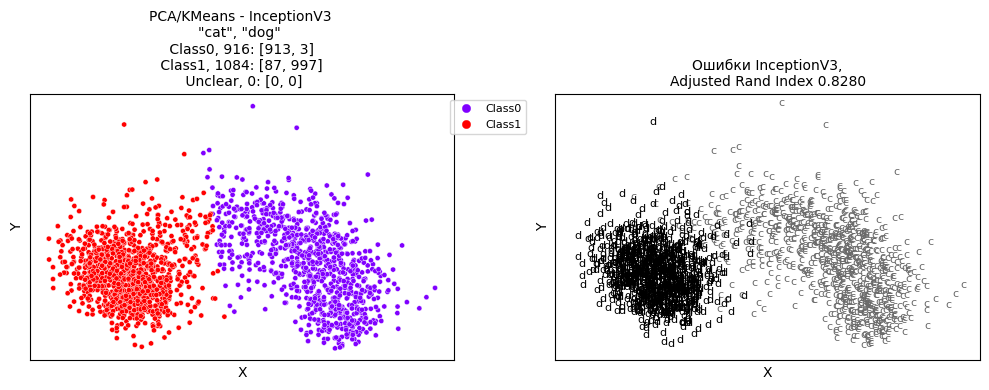

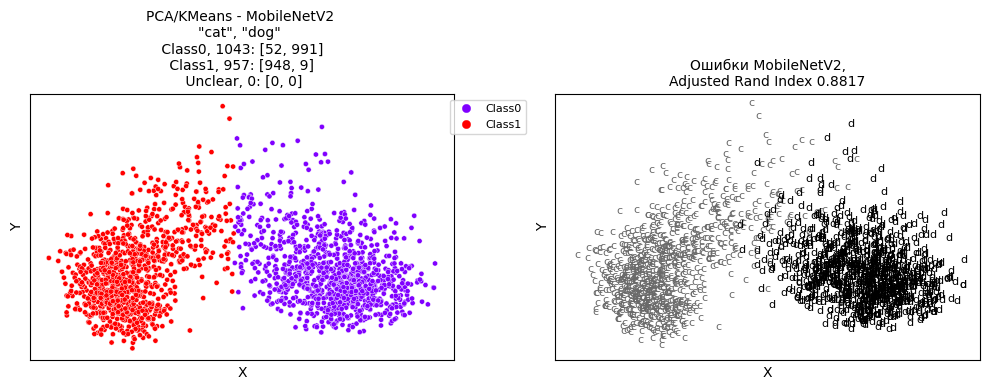

In [ ]:
# Вызов функции с кластеризатором KMeans

for i, model in enumerate(models):
    zzz(features_list[i], image_cluster, model, filess, kmeans=True, HDBSCAN=False, hierarchical=False)

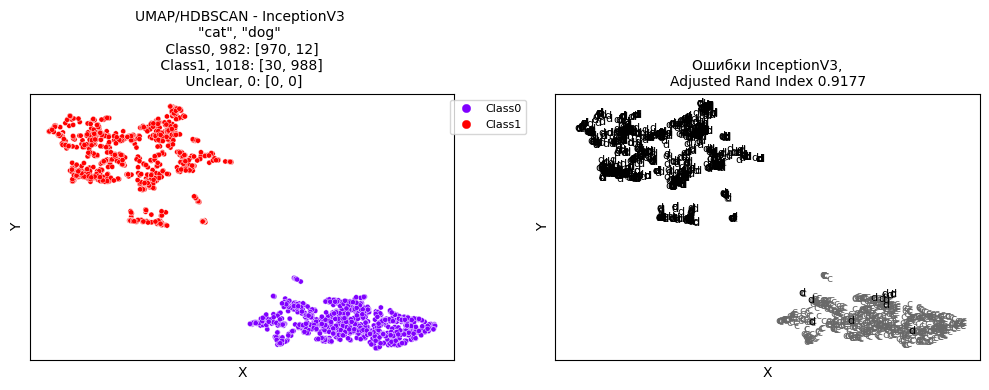

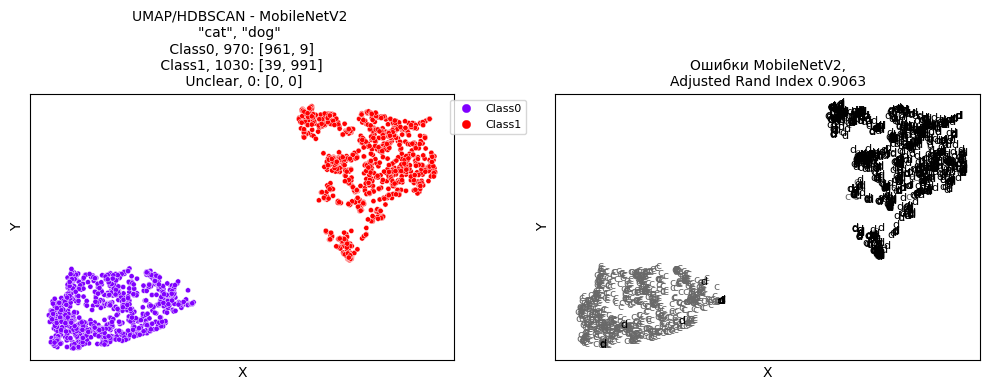

In [ ]:
# Вызов функции с кластеризатором HDBSCAN

for i, model in enumerate(models):
    zzz(features_list[i], image_cluster, model, filess, kmeans=False, HDBSCAN=True, hierarchical=False)

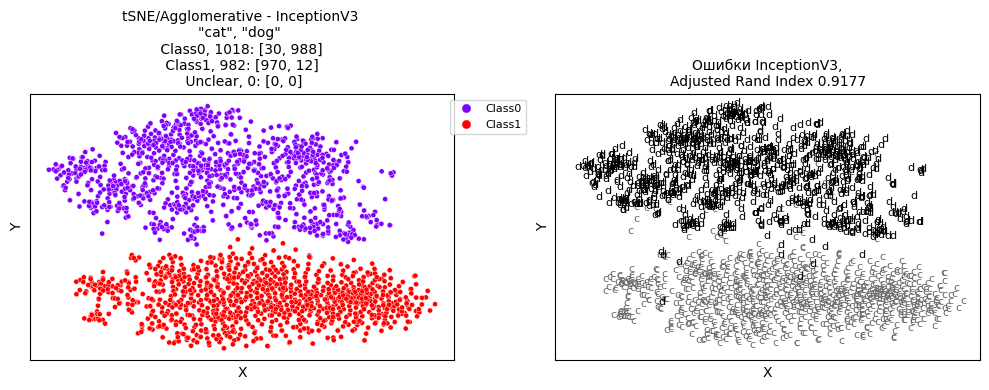

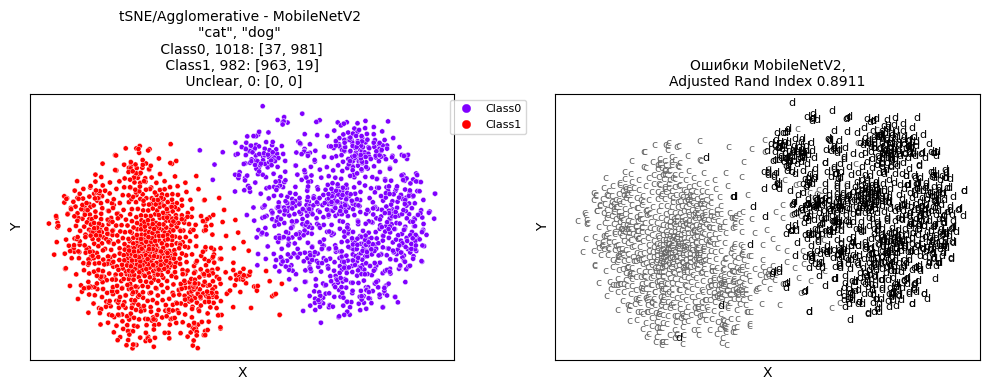

In [ ]:
# Вызов функции с кластеризатором Agglomerative

for i, model in enumerate(models):
    zzz(features_list[i], image_cluster, model, filess, kmeans=False, HDBSCAN=False, hierarchical=True)

**FGSM-атака, epsilon=0.01**

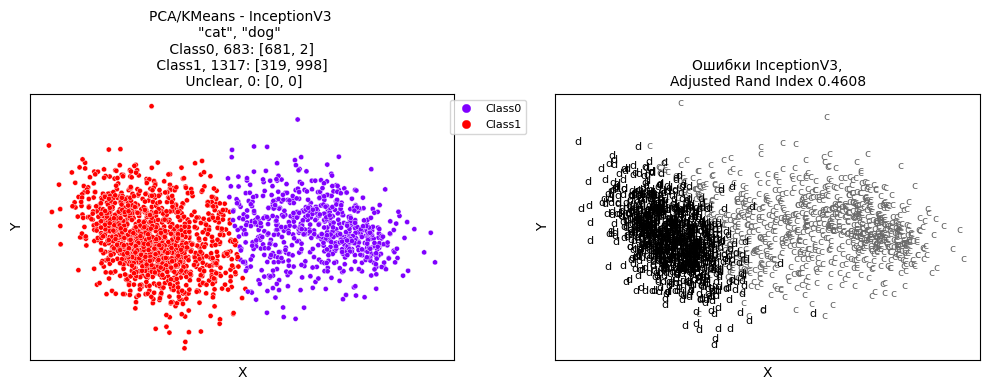

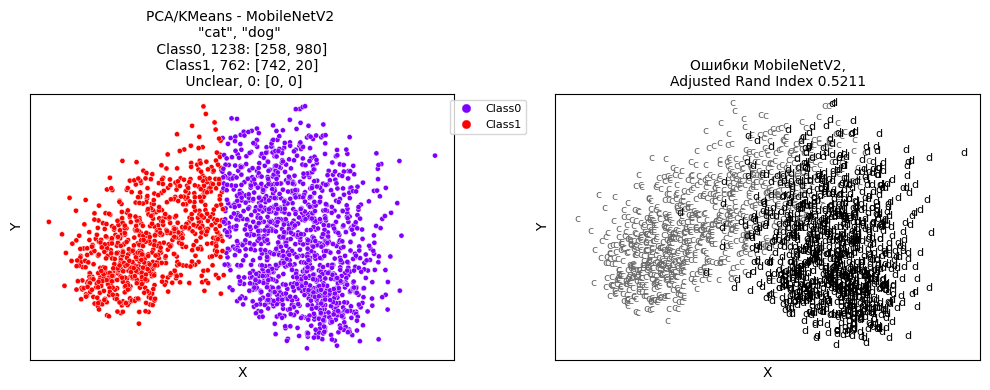

In [ ]:
# Вызов функции с кластеризатором KMeans

for i, model in enumerate(models):
    zzz(features_list[i], image_cluster, model, filess, kmeans=True, HDBSCAN=False, hierarchical=False)

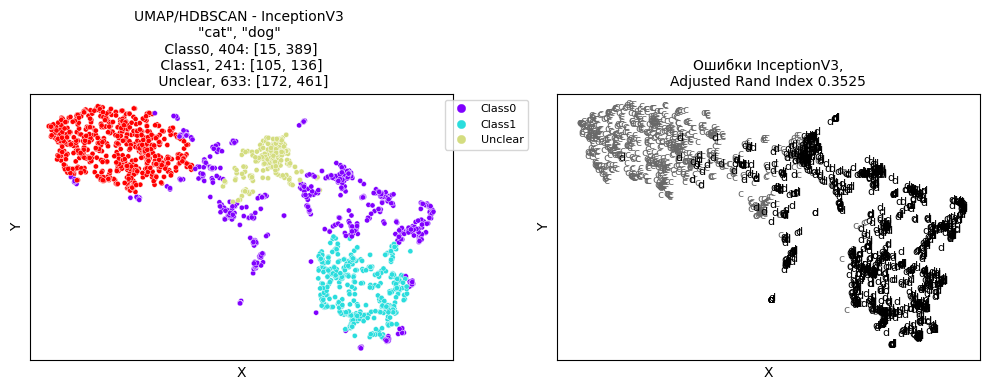

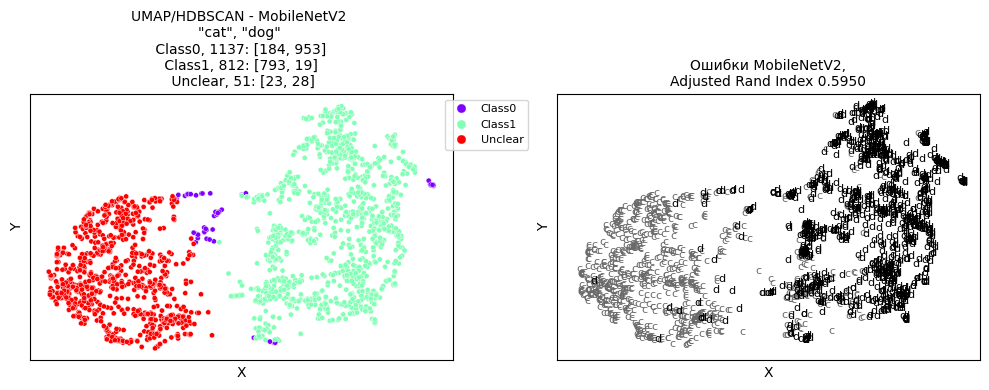

In [ ]:
# Вызов функции с кластеризатором HDBSCAN

'''
я не предусмотрела в коде дополнительные классы, так что на графике здесь и далее
Inceptionv2, который выделил сразу 4 класса, показывает неверную статистику
'''

for i, model in enumerate(models):
    zzz(features_list[i], image_cluster, model, filess, kmeans=False, HDBSCAN=True, hierarchical=False)

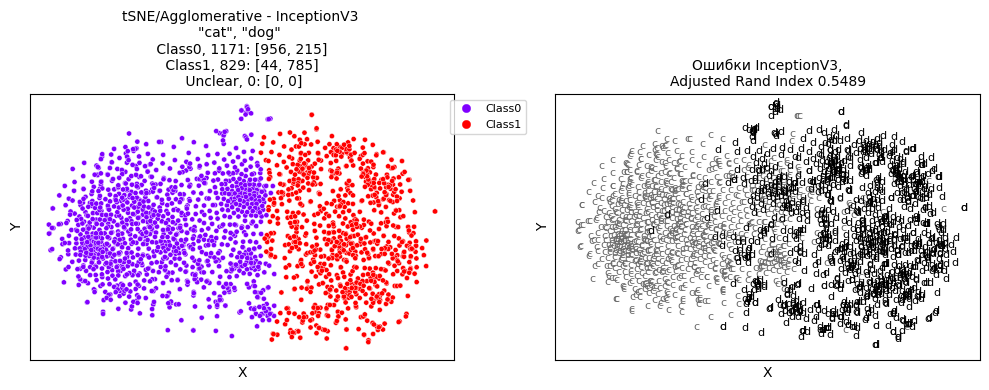

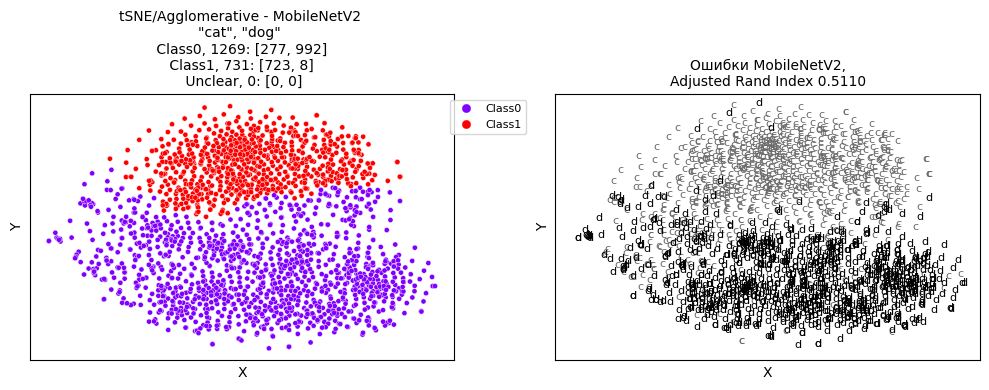

In [ ]:
# Вызов функции с кластеризатором Agglomerative

for i, model in enumerate(models):
    zzz(features_list[i], image_cluster, model, filess, kmeans=False, HDBSCAN=False, hierarchical=True)

**FGSM-атака, epsilon=0.05**

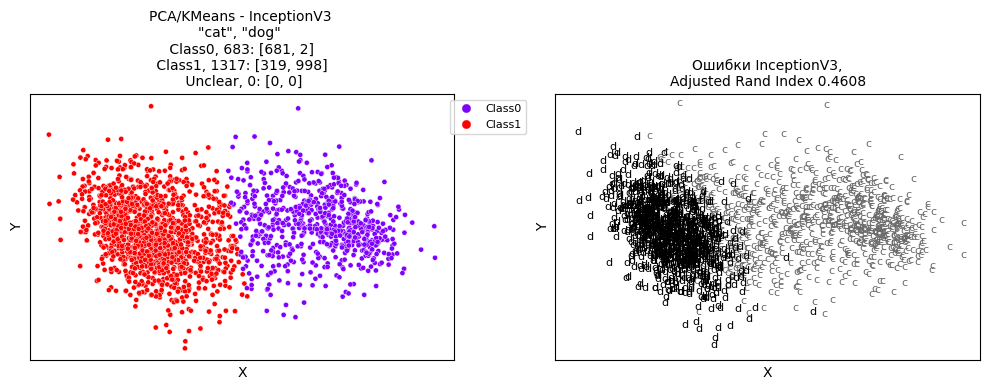

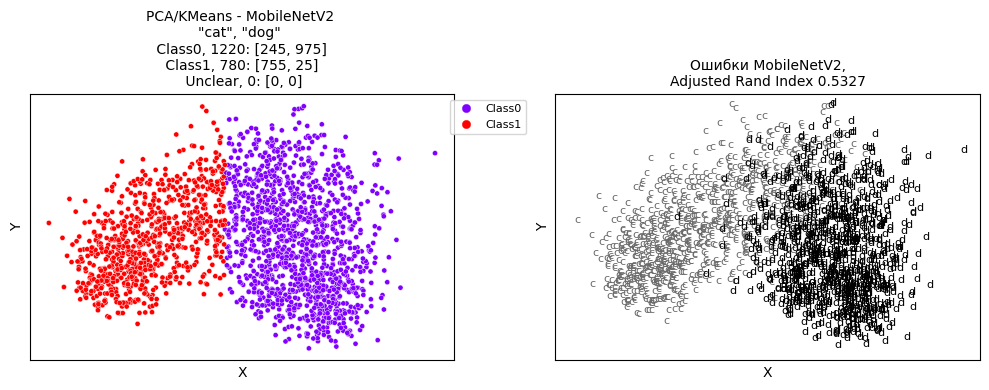

In [ ]:
# Вызов функции с кластеризатором KMeans

for i, model in enumerate(models):
    zzz(features_list[i], image_cluster, model, filess, kmeans=True, HDBSCAN=False, hierarchical=False)

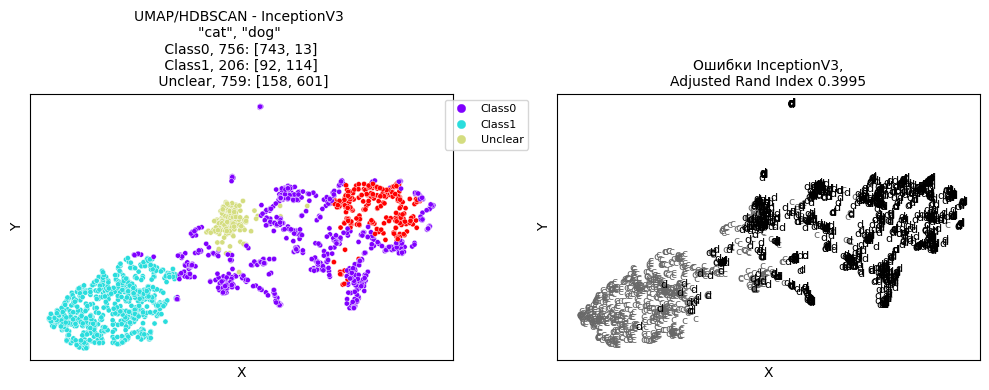

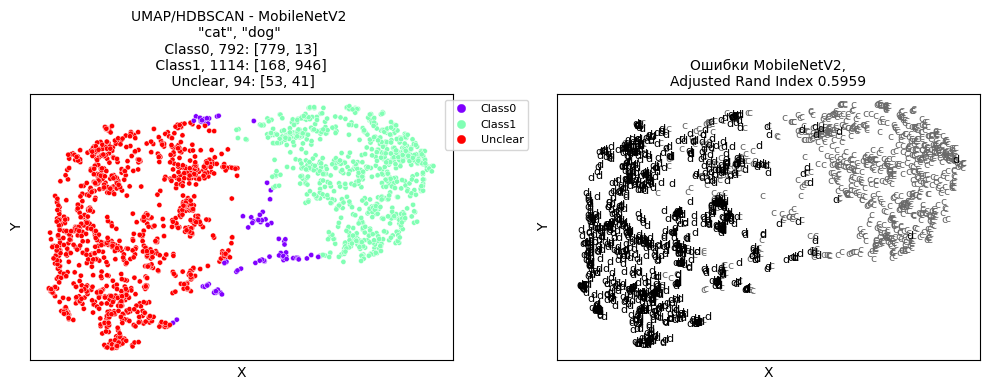

In [ ]:
# Вызов функции с кластеризатором HDBSCAN

for i, model in enumerate(models):
    zzz(features_list[i], image_cluster, model, filess, kmeans=False, HDBSCAN=True, hierarchical=False)

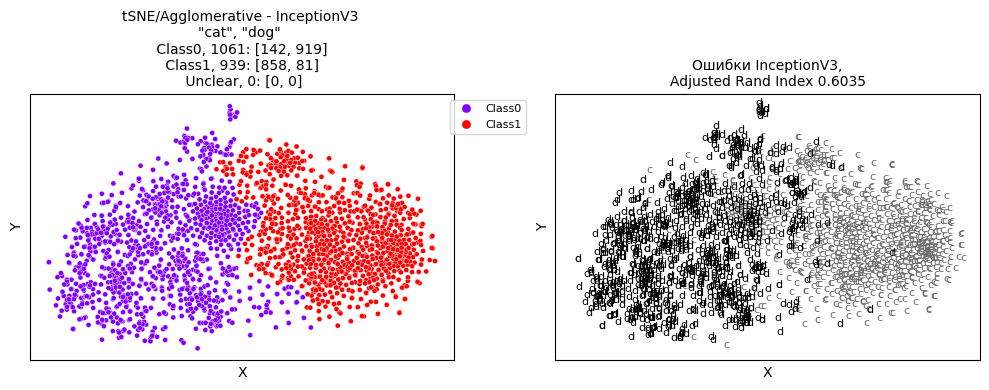

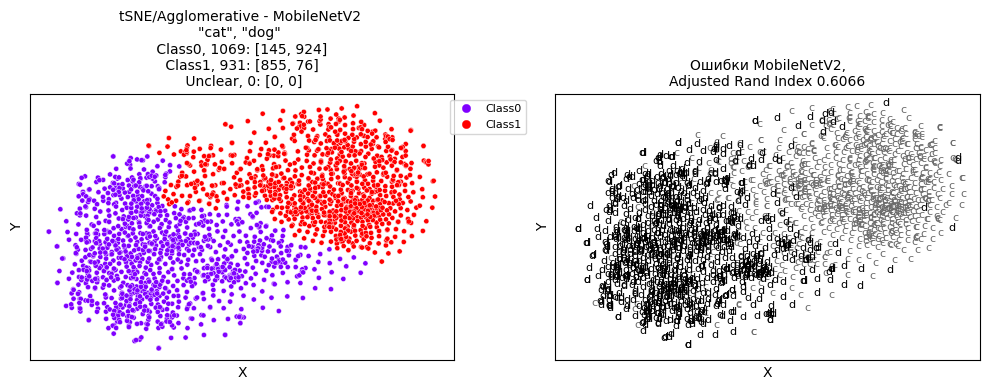

In [ ]:
# Вызов функции с кластеризатором Agglomerative

for i, model in enumerate(models):
    zzz(features_list[i], image_cluster, model, filess, kmeans=False, HDBSCAN=False, hierarchical=True)

**FGSM-атака, epsilon=0.1**


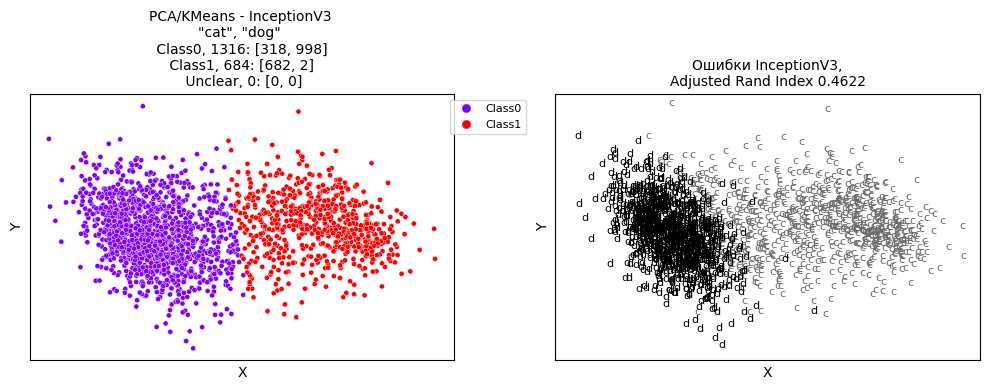

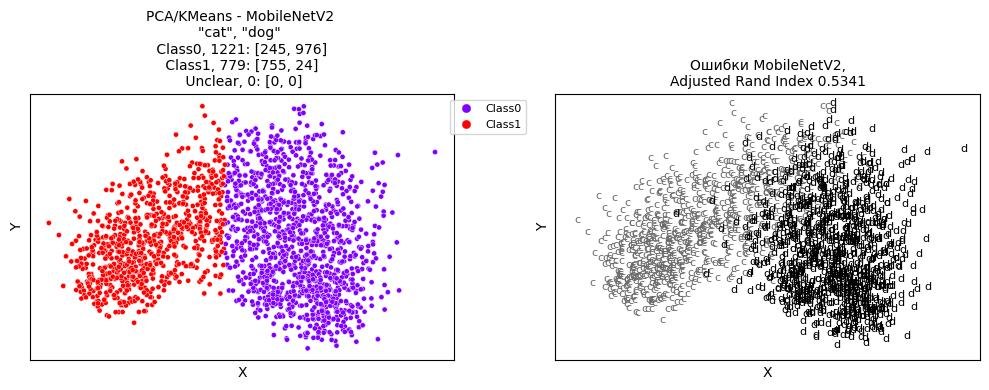

In [ ]:
# Вызов функции с кластеризатором KMeans

for i, model in enumerate(models):
    zzz(features_list[i], image_cluster, model, filess, kmeans=True, HDBSCAN=False, hierarchical=False)

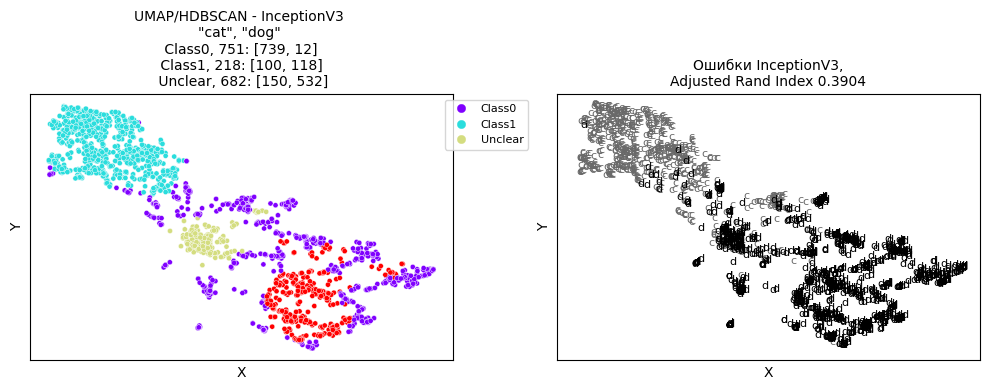

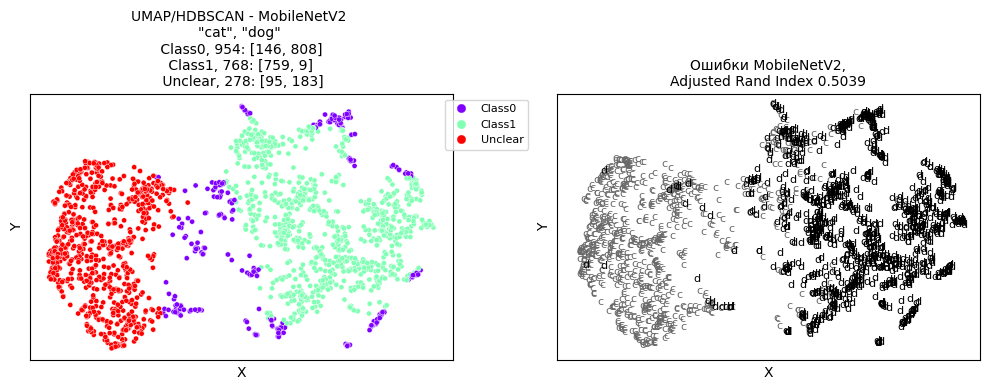

In [ ]:
# Вызов функции с кластеризатором HDBSCAN

for i, model in enumerate(models):
    zzz(features_list[i], image_cluster, model, filess, kmeans=False, HDBSCAN=True, hierarchical=False)

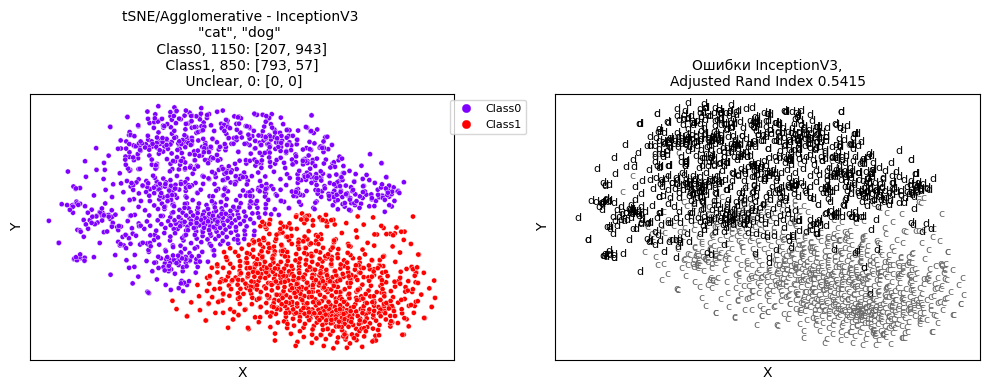

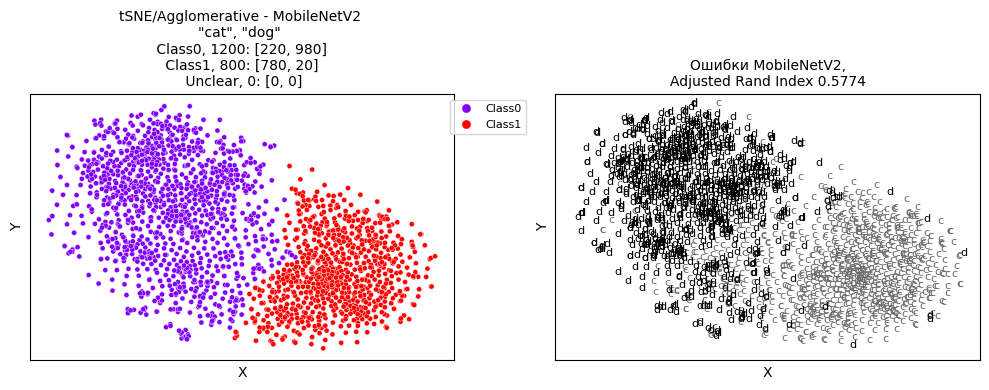

In [ ]:
# Вызов функции с кластеризатором Agglomerative

for i, model in enumerate(models):
    zzz(features_list[i], image_cluster, model, filess, kmeans=False, HDBSCAN=False, hierarchical=True)

**Результат**

Чтобы серьезно уменьшить возможности моделей правильно классифицировать данные, оказалось достаточно возмущения epsilon=0.01. Это следует как из визуализации кластеризации, которая выступает заменой метрики при классификации неразмеченных данных, так и из ARI - индекса сходства кластеров по истинной и кластерной маркировке.

Модель MobileNetV2 показала себя хоть и ненамного, но более устойчивой, чем InceptionV3.

Из удивительного. Совершенно рассыпалась кластеризатор UMAP/HDBSCAN.

In [ ]:
links = ['/content/drive/MyDrive/AdvAttacks/Сlean2000/Models_Clean2000/FFF/ari_kmeans_Insep.txt',
         '/content/drive/MyDrive/AdvAttacks/Сlean2000/Models_Clean2000/FFF/ari_HDBSCAN2_Insep.txt',
         '/content/drive/MyDrive/AdvAttacks/Сlean2000/Models_Clean2000/FFF/ari_hierarchical_Insep.txt',
         '/content/drive/MyDrive/AdvAttacks/Сlean2000/Models_Clean2000/FFF/ari_kmeans_Mob.txt',
         '/content/drive/MyDrive/AdvAttacks/Сlean2000/Models_Clean2000/FFF/ari_HDBSCAN2_Mob.txt',
         '/content/drive/MyDrive/AdvAttacks/Сlean2000/Models_Clean2000/FFF/ari_hierarchical_Mob.txt'
         ]

results = []

for link in links:
    with open(link, 'r') as file:
        content = file.readlines()
        values = [float(line.strip()) for line in content]
        results.append(values)

KM_Insep, HD_Insep, tA_Insep, KM_Mob, HD_Mob, tA_Mob = results

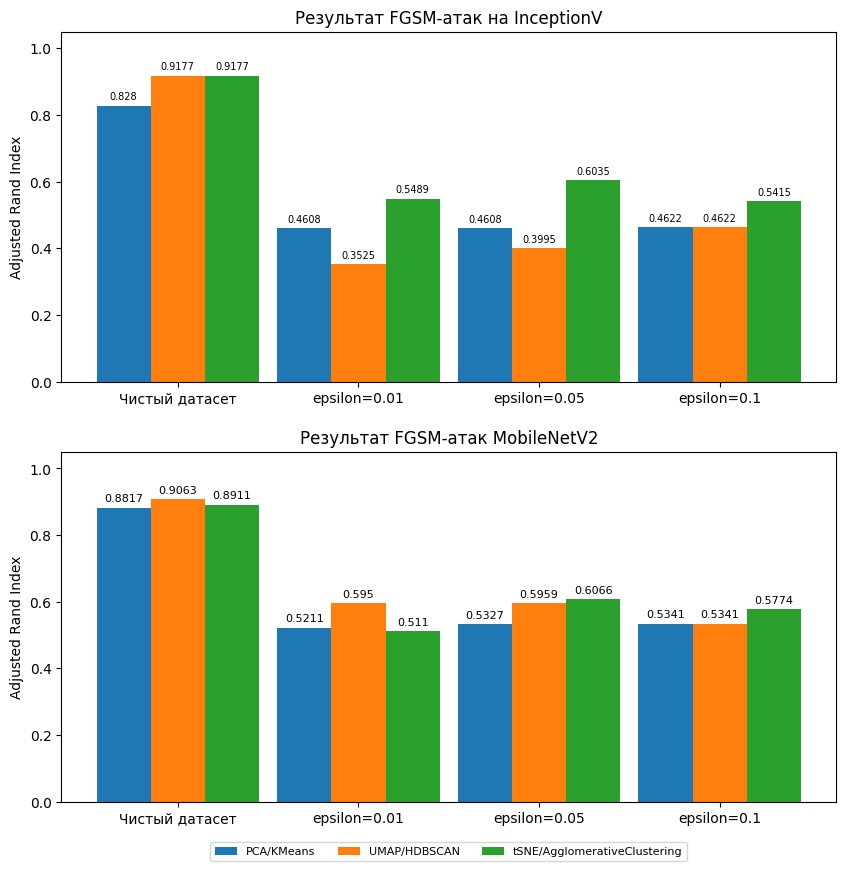

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
models1 = ('Чистый датасет', 'epsilon=0.01', 'epsilon=0.05', 'epsilon=0.1')
models2 = ('Чистый датасет', 'epsilon=0.01', 'epsilon=0.05', 'epsilon=0.1')
x1 = np.arange(len(models1))
x2 = np.arange(len(models2))
width = 0.3
multiplier = 0

models_means1 = {'PCA/KMeans': KM_Insep,
                'UMAP/HDBSCAN': HD_Insep,
                'tSNE/AgglomerativeClustering': tA_Insep}
models_means2 = {'PCA/KMeans': KM_Mob,
                 'UMAP/HDBSCAN': HD_Mob,
                'tSNE/AgglomerativeClustering': tA_Mob}

for attribute, measurement in models_means1.items():
    offset = width * multiplier
    rects = ax[0].bar(x1 + offset, measurement, width, label=attribute)
    ax[0].bar_label(rects, padding=3, fontsize=7)
    multiplier += 1

for attribute, measurement in models_means2.items():
    offset = width * multiplier
    rects = ax[1].bar(x2 + offset, measurement, width, label=attribute)
    ax[1].bar_label(rects, padding=3, fontsize=8)
    multiplier += 1

ax[0].set_ylabel('Adjusted Rand Index')
ax[0].set_title('Результат FGSM-атак на InceptionV')
ax[0].set_xticks(x1 + width)
ax[0].set_xticklabels(models1)
ax[0].set_ylim(0, 1.05)

ax[1].set_ylabel('Adjusted Rand Index')
ax[1].set_title('Результат FGSM-атак MobileNetV2')
ax[1].set_xticks(x2 + width * 4)
ax[1].set_xticklabels(models2)
ax[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fontsize=8, markerscale=1, ncol=3)
ax[1].set_ylim(0, 1.05)

plt.show()
